In [1]:
import getpass
import os
from dotenv import load_dotenv

load_dotenv() # load from .env file

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.5-flash-lite", model_provider="google_genai")

In [2]:
# embedding

from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

from langchain_core.vectorstores import InMemoryVectorStore
vector_store = InMemoryVectorStore(embeddings)

In [3]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict



# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [ ]:
# # same thing but written slightly differently, and better

# from langchain_community.document_loaders import WebBaseLoader

# urls = [
#     "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
#     "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
#     "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
# ]

# docs = [WebBaseLoader(url).load() for url in urls]


# from langchain_text_splitters import RecursiveCharacterTextSplitter
# docs_list = [item for sublist in docs for item in sublist]

# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=100, chunk_overlap=50
# )
# doc_splits = text_splitter.split_documents(docs_list)



In [36]:
all_splits[0].page_content


'LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'

## RAG workflow

In [19]:

# Define prompt for question-answering
# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [ ]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(step, end="|\n")

{'retrieve': {'context': [Document(id='5edda4fa-b1aa-47d6-bf91-10ff288fc2e6', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assu

## Agent tool calling RAG

In [25]:
from langchain_core.messages import SystemMessage
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

# allow model to re-write user queries to include context based on past messages

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

"""
1. User inputs as HumanMessage
2. query to vector store as AIMessage(with tool calls)
3. query result comes back as ToolMessage
4. finally generate() responds as AIMessage
"""


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """ retrieve information related to a query"""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

tools_set = [retrieve]
llm_with_tools = llm.bind_tools(tools_set)

# node 1
def query_or_respond(state: MessagesState):
    response = llm_with_tools.invoke(state['messages'])
    
    return {"messages" : [response]}

# node 2 - node to do tool calls, adds result as a ToolMessage to the state
tool_node = ToolNode(tools=tools_set)

# node 3
def generate(state: MessagesState):
    # collect all the retrieved context
    recent_tool_msgs = []
    for msg in reversed(state['messages']):
        if msg.type == 'tool':
            recent_tool_msgs.append(msg)
        else:
            break
    tool_msgs = recent_tool_msgs[::-1] # reverse
    
    context_combined = "\n\n".join(doc.content for doc in tool_msgs)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{context_combined}"
    )
    
    # non tool calls
    conversation_msgs = [
        msg
        for msg in state["messages"]
        if msg.type in ('system', 'human')
        or msg.type == 'ai' and not msg.tool_calls
    ]
    past_convo = [SystemMessage(system_message_content)] + conversation_msgs
    
    response = llm.invoke(past_convo)
    return {"messages" : [response]}
    

In [21]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

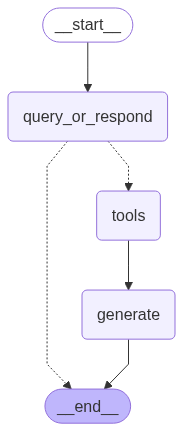

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
from langchain_core.messages import HumanMessage


input_message = "what is self-reflection?"

for step in graph.stream(
    {"messages": [HumanMessage(content=input_message)]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

what is self-reflection?
================================== Ai Message ==================================
Tool Calls:
  retrieve (13b8a56d-99a3-4100-8cac-848c73e3201a)
 Call ID: 13b8a56d-99a3-4100-8cac-848c73e3201a
  Args:
    query: what is self-reflection?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Self-Reflection#
Self-reflection is a vital aspect that allows autonomous agents to improve iteratively by refining past action decisions and correcting previous mistakes. It plays a crucial role in real-world tasks where trial and error are inevitable.
ReAct (Yao et al. 2023) integrates reasoning and acting within LLM by extending the action space to be a combination of task-specific discrete actions and the language space. The former enables LLM to interact with the envir

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents: contents is not specified
